# Color Project
Tim Bischoff (INSERT STUDENT ID), Zabi Azimy (INSERT STUDENT ID and NAME), Paul Wecker (INSERT STUDENT ID)

## Table of Contents:
1. [Task Overview](#overview)
2. [Loading and Transforming Data](#loading)
    1. [Helper functions](#functions)
    2. [Loading, Preprocessing](#prep)
3. [Figures](#three)
    1. [Boxplots for each color value](#3.1)
    2. [Histograms for $\Delta$ e Values for each color spot](#3.2)
    3. [Boxplot for $\Delta$ e Values for each color spot](#3.3)
    4. [Scatter: print master vs measurements](#3.4)
    5. [Standard Deviations of color values (L, a, b)](#3.4)
4. [Four](#four)
5. [Five](#five)
6. [Six](#six)
7. [Seven](#seven)
8. [eight](#eight)

## 1 Task Overview <a class="anchor" id="overview"></a>

#### As in handout...
Use visualization tools for describing what’s going on in these data. Possible aspects:
- How do colors behave relative to the print master?
    - on individual scales L, a, b?
    - in 3-dimensional "L-a-b" space?
- How does color dispersion behave?
    - on individual scales L, a, b?
    - in 3-dimensional "L-a-b" space?
- It may be of interst to familiarize yourself with delta-E values
- Is the behavior differntial between targets?
- Is the behavior differential between color spots?
- Is quality possibly related to the intended color?
Make use of "small multiples" in useful ways.

## 2 Loading and Transforming Data


### 2.1 Helper functions and imports <a class="anchor" id="functions"></a>
The first paragraph text

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import copy
import colorspacious as cs
from sklearn.cluster import KMeans

from typing import Tuple, List

In [2]:
def delta_e(L, a, b, L_m, a_m, b_m):
    return np.sqrt( (L-L_m)**2 + (a-a_m)**2 + (b-b_m)**2)

In [9]:
def create_scatter_data(master_colors: pd.DataFrame,
                        measurements: pd.DataFrame,
                        color: str) -> Tuple[List,List]:
    x = []
    y = []
    for row in range(1,9):
        for col in range(1,9):
            x += [master_colors.loc[(row, col)][color]]*546
            y += measurements[color+str(row)+str(col)].to_list()
    return x, y

In [8]:
def create_scatter_data_std(df_stds: pd.DataFrame,
                            master_colors: pd.DataFrame,
                            color: str
                            ) -> Tuple[List, List]:
    x = []
    y = []
    c = []
    for row, col in master_colors.index:
        x.append(master_colors.loc[(row, col)][color])
        y.append(df_stds[(df_stds["rows"]==row)&(df_stds["cols"]==col)][f"std_{color}"])
        c.append(master_colors.loc[row, col]["cluster"])
    return x, y, c

### 2.2 Load data and preprocessing <a class="anchor" id="prep"></a>

#### Data Preprocessing Tim

In [10]:
measurments = pd.read_csv("data/LabMeasurements-Color-Card.csv", decimal=',', sep=';')
master_colors = pd.read_csv("data/MasterColorCard.csv", decimal=',', sep=';')

# make multilevel index for measurments columns
row = measurments['Row']
col = measurments['Column']
measurments = measurments.drop(['Row', 'Column'], axis=1)
new_cols = pd.MultiIndex.from_tuples(
    [(int(col[1:]), col[0]) for col in measurments.columns]
)
measurments.columns = new_cols
measurments.insert(0, 'Row', row)
measurments.insert(1, 'Column', col)

# make multilevel index for master color rows
master_colors.set_index(['Crow', 'Ccol'], inplace=True)

Delta-E values for 3 dimensional analysis

In [17]:
# compute delta e values
delta_e_values = np.zeros((546, 64))

min_error = 0
max_error = 0

for i in range(546):
    j = 0
    for row in range(1,9):
        for col in range(1,9):
            spot = row*10+col
            L_master = master_colors.loc[row, col]['L']
            a_master = master_colors.loc[row, col]['a']
            b_master = master_colors.loc[row, col]['b']

            L = measurments.loc[i, (spot, 'L')]
            a = measurments.loc[i, (spot, 'a')]
            b = measurments.loc[i, (spot, 'b')]

            delta_e_values[i, j] = delta_e(L, a, b, L_master, a_master, b_master)
            j += 1

Error computation for each color value (L, a, b)

In [24]:
# compute errors
errors = copy(measurments)
for row in range(1,9):
    for col in range(1,9):
        spot = row*10+col

        master_L = master_colors.loc[row, col]['L']
        master_a = master_colors.loc[row, col]['a']
        master_b = master_colors.loc[row, col]['b']

        errors.loc[:, (spot, 'L')] = errors.loc[:, (spot, 'L')] - master_L
        errors.loc[:, (spot, 'a')] = errors.loc[:, (spot, 'a')] - master_a
        errors.loc[:, (spot, 'b')] = errors.loc[:, (spot, 'b')] - master_b

#### Pauls Preprocessing

Compute standard deviations

In [11]:
measurements = pd.read_csv("data/LabMeasurements-Color-Card.csv", decimal=',', sep=';')
rows = []
cols = []
std_L = []
std_a = []
std_b = []
for row in range(1,9):
    for col in range(1,9):
        std_L.append(measurements["L"+str(row)+str(col)].std())
        std_a.append(measurements["a"+str(row)+str(col)].std())
        std_b.append(measurements["b"+str(row)+str(col)].std())
        rows.append(row)
        cols.append(col)
df_stds = pd.DataFrame(data={"rows":rows,
                             "cols":cols,
                             "std_L":std_L,
                             "std_a":std_a,
                             "std_b":std_b})

Remove color spots which are duplicated (only grey, but there are many)

In [12]:
grouped = master_colors.groupby(['L', 'a', 'b'])['Field'].apply(list).reset_index()
grey_fields =grouped.loc[17]["Field"]
master_colors_filtered = master_colors[~master_colors["Field"].isin(grey_fields)]

Plot Elbow Chart for K-Means on remaining colors

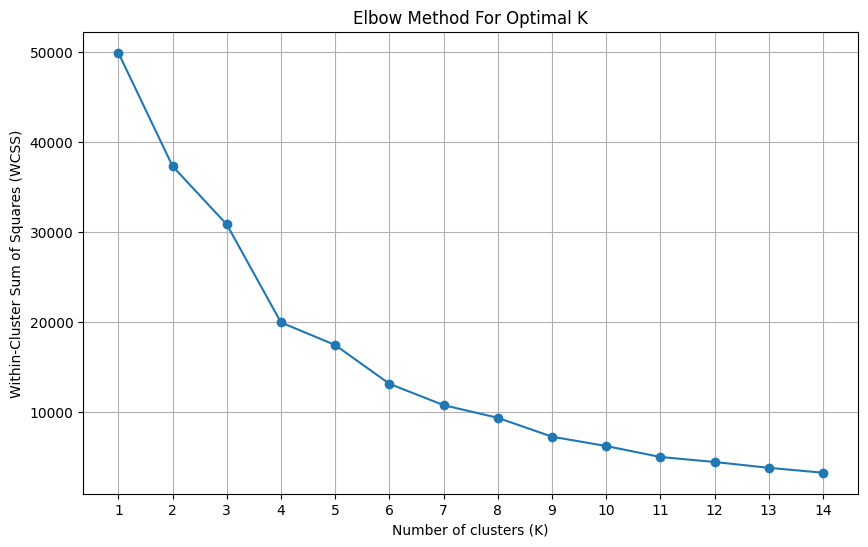

In [15]:
X = master_colors_filtered[['L', 'a', 'b']]

# Compute WCSS for different values of K
wcss = []
K_range = range(1, 15)  # Testing K from 1 to 10

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

Assign clusters with K=4

In [16]:
kmeans = KMeans(n_clusters=4, random_state=0)
master_colors_filtered["cluster"] = kmeans.fit_predict(X)

/var/folders/3h/sbptm41s5b10cqlvkhtzl1_h0000gn/T/ipykernel_82293/1463118047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_colors_filtered["cluster"] = kmeans.fit_predict(X)


## 3 List of Figures (give this bit a good title) <a class="anchor" id="three"></a>

#### 3.1 Boxplot for each color value (L, a, b) for each color spot <a class="anchor" id="3.1"></a>

In [1]:
fig, axes = plt.subplots(8,8, figsize=(24,24))

# TODO: use distinct colors for boxplots, they sometimes blend into the background

for row in range(1,9):
    for col in range(1,9):
        ax = axes[row-1, col-1]
        spot = row*10+col

        if spot in [11, 18, 81, 88]:
            circle = patches.Circle((0.0, 0.0), 10, facecolor='gray', edgecolor='black')
            ax.add_patch(circle)
            ax.set_aspect('equal')
            ax.set_xlim([-10.5,10.5])
            ax.set_ylim([-10.5,10.5])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        L = errors[spot]['L'].values
        a = errors[spot]['a'].values
        b = errors[spot]['b'].values

        L_master = master_colors.loc[row, col]['L']
        a_master = master_colors.loc[row, col]['a']
        b_master = master_colors.loc[row, col]['b']
        master_color = cs.cspace_convert([L_master, a_master, b_master], "CIELab", "sRGB1")
        master_color = np.clip(master_color, 0, 1)

        bplt = ax.boxplot([L,a,b], patch_artist=True)

        # format plot
        ax.set_facecolor(master_color)
        ax.axhline(0, color='black', linestyle='--')
        ax.set_xticks([1,2,3], ['L', 'a', 'b'])
        ax.set_ylabel('Error')
        ax.set_title(f"Spot {spot}")
        #ax.set_ylim([-11, 11])

plt.tight_layout()
plt.savefig("figures/boxplots.png")

NameError: name 'plt' is not defined

#### 3.2 Histograms of $\Delta$ E Values for each color spot  <a class="anchor" id="3.2"></a>

In [2]:
fig, axes = plt.subplots(8,8, figsize=(24,24))

max_error = np.max(delta_e_values)

j = 0
for row in range(1,9):
    for col in range(1,9):
        ax = axes[row-1, col-1]
        spot = row*10+col

        if spot in [11, 18, 81, 88]:
            circle = patches.Circle((0.0, 0.0), 10, facecolor='gray', edgecolor='black')
            ax.add_patch(circle)
            ax.set_aspect('equal')
            ax.set_xlim([-10.5,10.5])
            ax.set_ylim([-10.5,10.5])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        L_master = master_colors.loc[row, col]['L']
        a_master = master_colors.loc[row, col]['a']
        b_master = master_colors.loc[row, col]['b']
        master_color = cs.cspace_convert([L_master, a_master, b_master], "CIELab", "sRGB1")
        master_color = np.clip(master_color, 0, 1)
        ax.set_facecolor(master_color)

        hist_color = 'white' if L_master < 47 else 'black'
        ax.hist(delta_e_values[:, j], color=hist_color)

        ax.set_xlim([0, max_error])
        ax.set_ylabel('Instances')
        ax.set_xlabel(r'$\Delta$ e')
        ax.set_title(str(spot))
        j += 1

plt.tight_layout()
plt.savefig('figures/delta_e_hists.png')

NameError: name 'plt' is not defined

#### 3.3 Boxplot for $\Delta$ e Values for each color spot  <a class="anchor" id="3.3"></a>

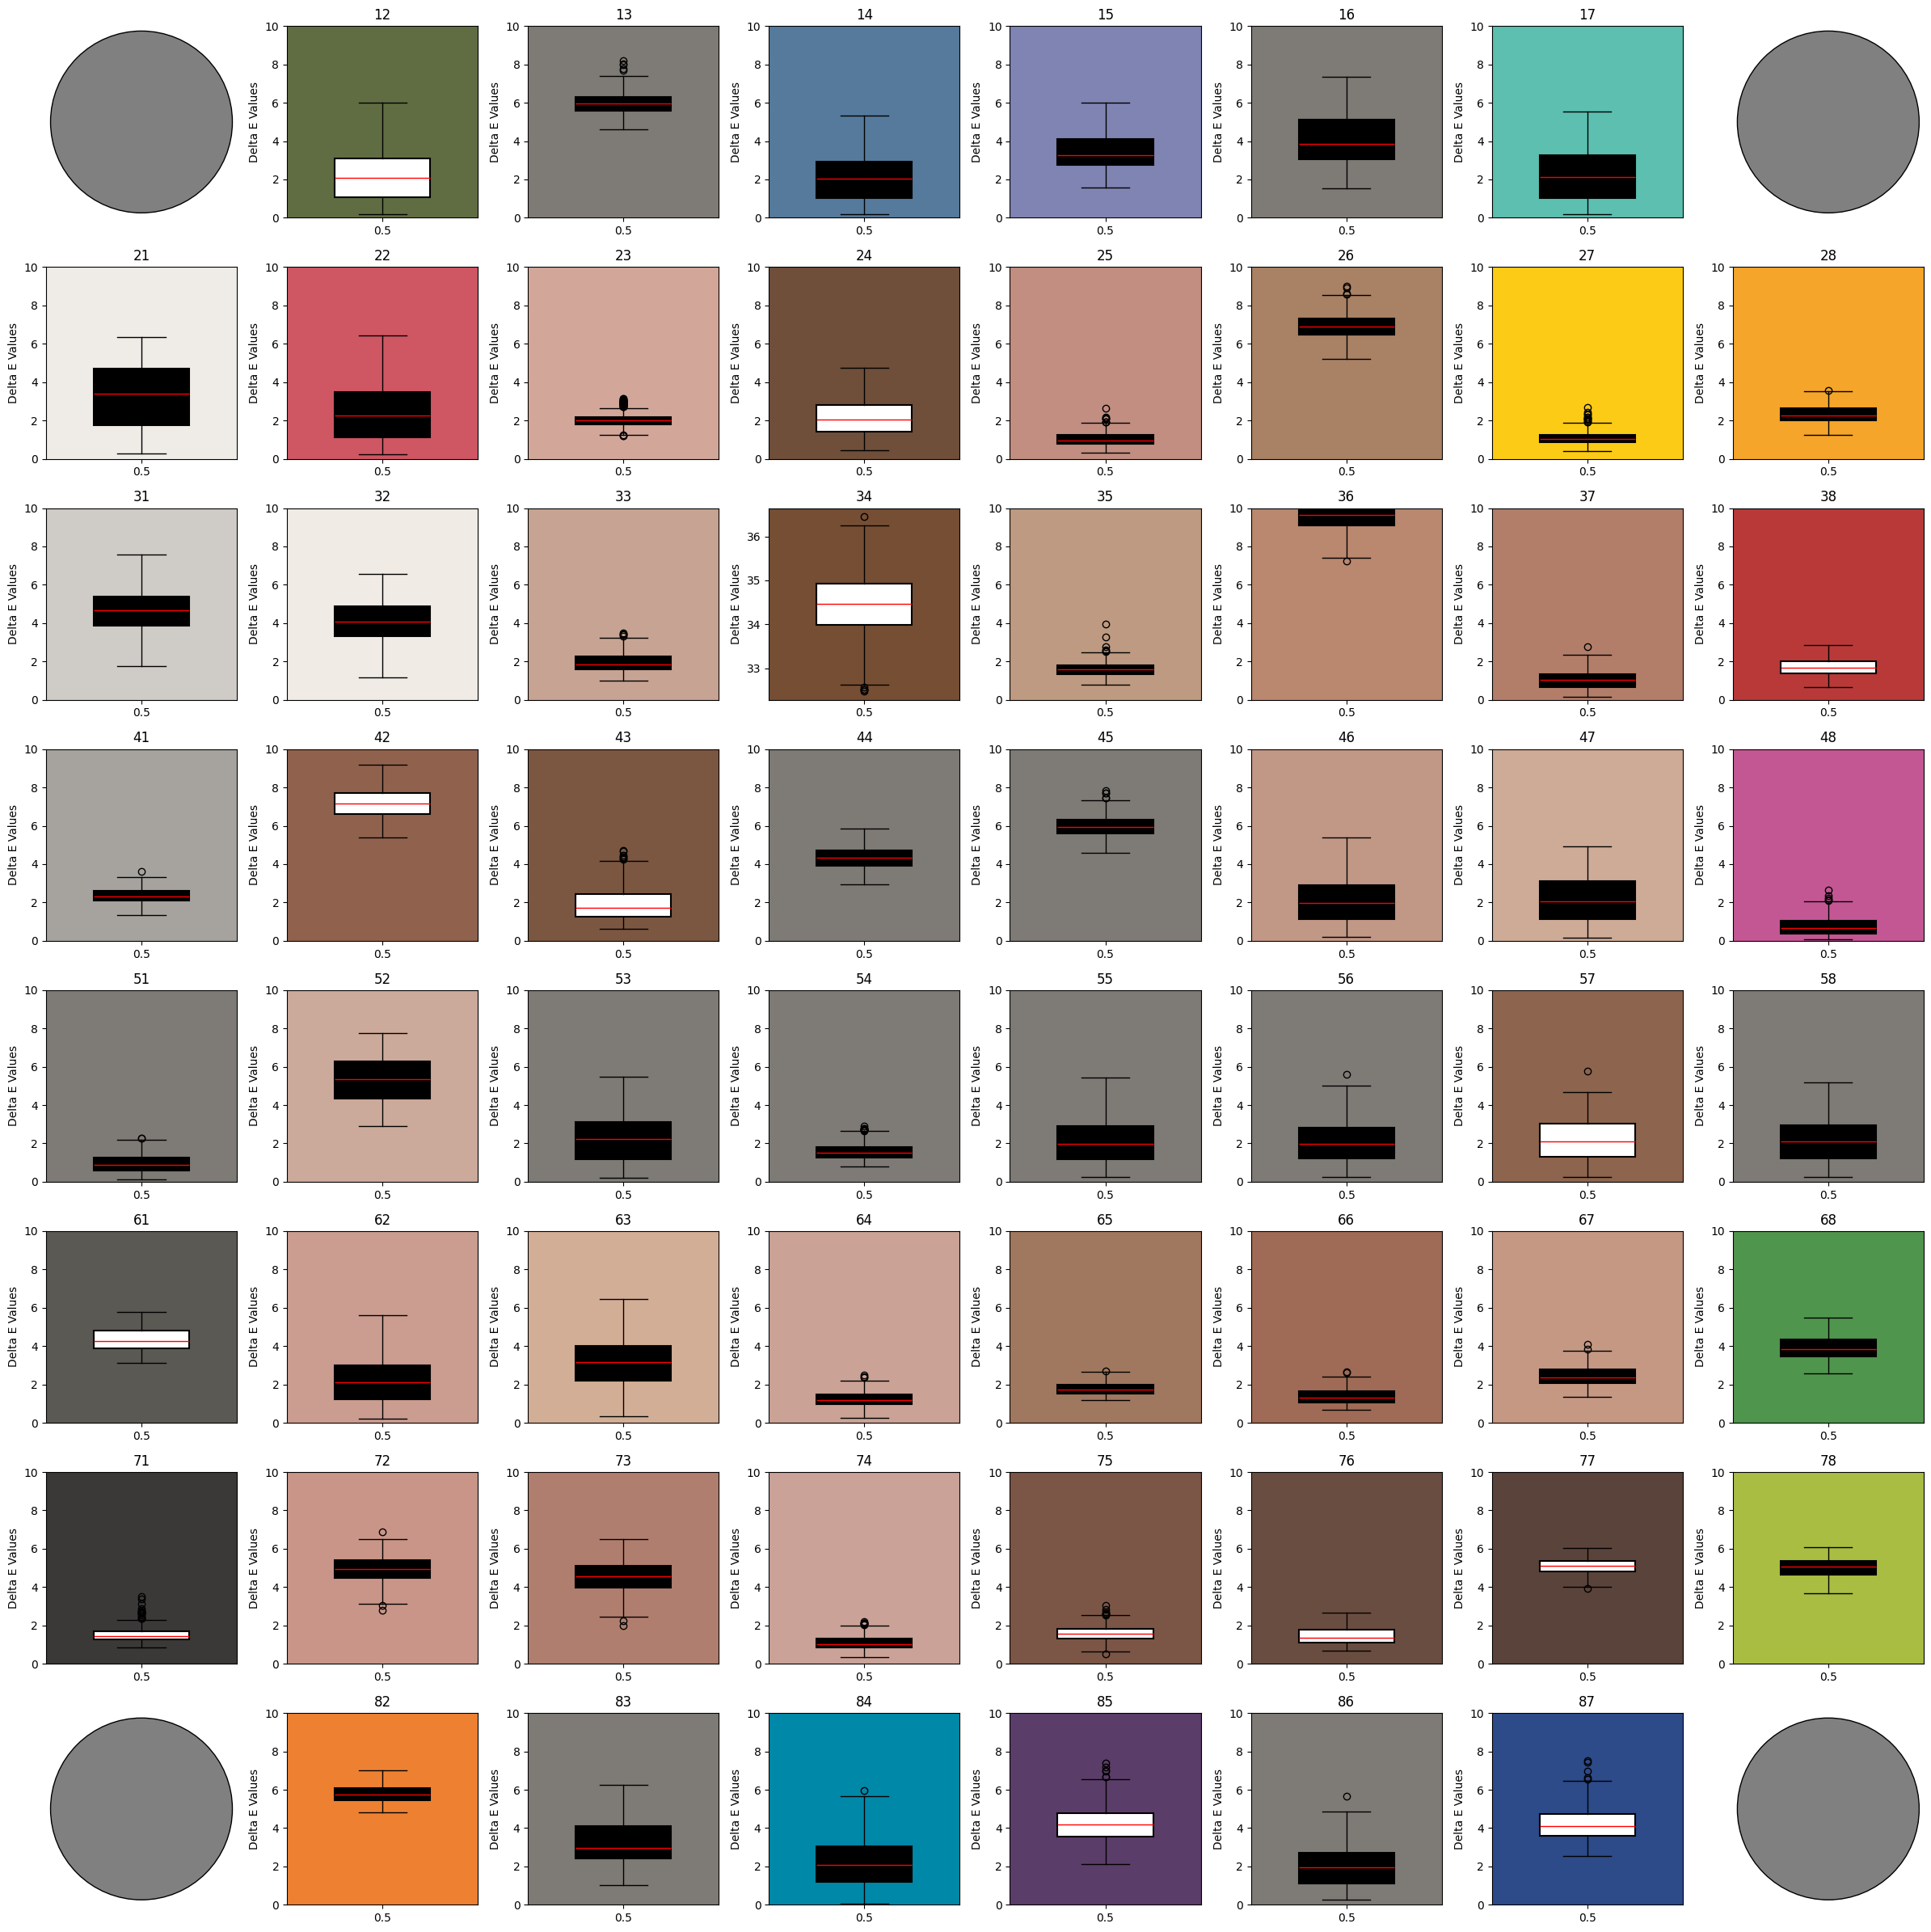

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import colorspacious as cs

fig, axes = plt.subplots(8, 8, figsize=(24, 24))

max_error = np.max(delta_e_values)

j = 0
for row in range(1, 9):
    for col in range(1, 9):
        ax = axes[row - 1, col - 1]
        spot = row * 10 + col

        if spot in [11, 18, 81, 88]:
            circle = patches.Circle((0.0, 0.0), 10, facecolor='gray', edgecolor='black')
            ax.add_patch(circle)
            ax.set_aspect('equal')
            ax.set_xlim([-10.5, 10.5])
            ax.set_ylim([-10.5, 10.5])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        L_master = master_colors.loc[row, col]['L']
        a_master = master_colors.loc[row, col]['a']
        b_master = master_colors.loc[row, col]['b']
        master_color = cs.cspace_convert([L_master, a_master, b_master], "CIELab", "sRGB1")
        master_color = np.clip(master_color, 0, 1)
        ax.set_facecolor(master_color)

        hist_color = 'white' if L_master < 47 else 'black'
        # Change histogram to boxplot, centered
        ax.boxplot(delta_e_values[:, j], patch_artist=True, boxprops=dict(facecolor=hist_color, color='black', linewidth=1.5), medianprops=dict(color='red'), widths=0.5, positions=[0.5])

        ax.set_xlim([0, 1])  # Center the boxplot
        if spot != 34:
            ax.set_ylim([0, 10])
        ax.set_ylabel('Delta E Values')
        ax.set_xlabel('')
        ax.set_title(str(spot))
        j += 1

plt.tight_layout()
plt.savefig('figures/delta_e_boxplots.png')


#### 3.4 Scatter: print master vs measurements  <a class="anchor" id="3.4"></a>

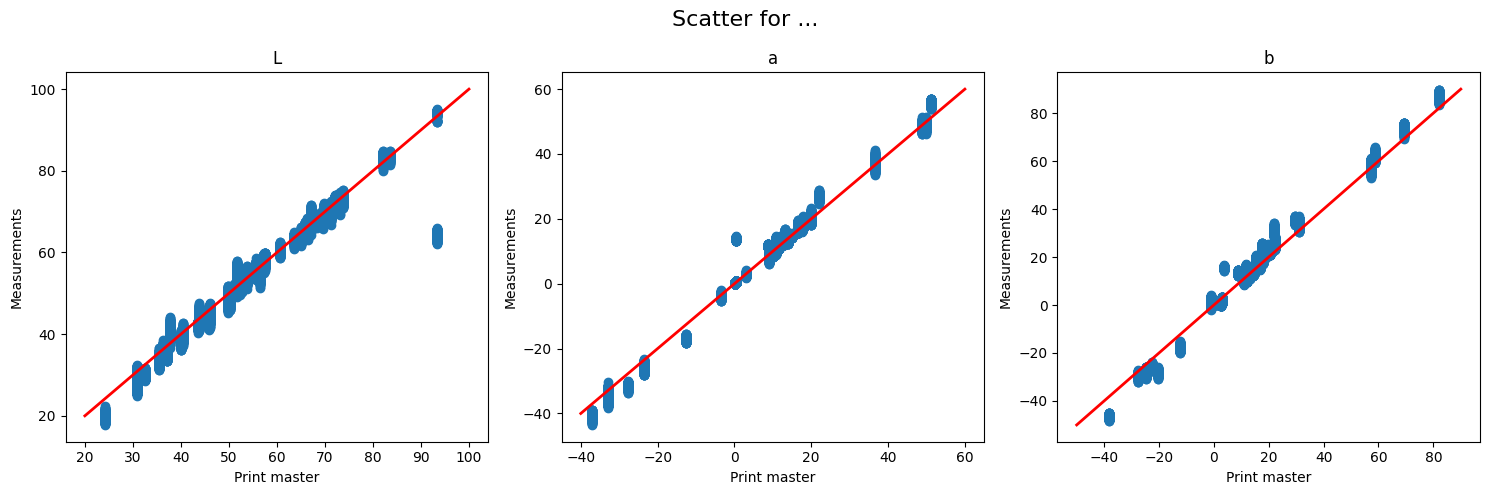

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, color in enumerate(["L", "a", "b"]):
    x, y = create_scatter_data(master_colors, measurements, color)
    axes[i].scatter(x, y)
    if color == "L":
        axes[i].plot([20, 100], [20, 100], color='red', linestyle='-', linewidth=2)
    elif color == "a":
        axes[i].plot([-40, 60], [-40, 60], color='red', linestyle='-', linewidth=2)
    else:
        axes[i].plot([-50, 90], [-50, 90], color='red', linestyle='-', linewidth=2)
    axes[i].set_title(f"{color}")
    axes[i].set_xlabel("Print master")
    axes[i].set_ylabel("Measurements")

fig.suptitle("Scatter for ...", fontsize=16)
plt.tight_layout()
plt.show()

#### 3.5 Standard Deviations of color values (L, a, b) (colored by cluster) (grey duplicates filtered out)  <a class="anchor" id="3.5"></a>

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


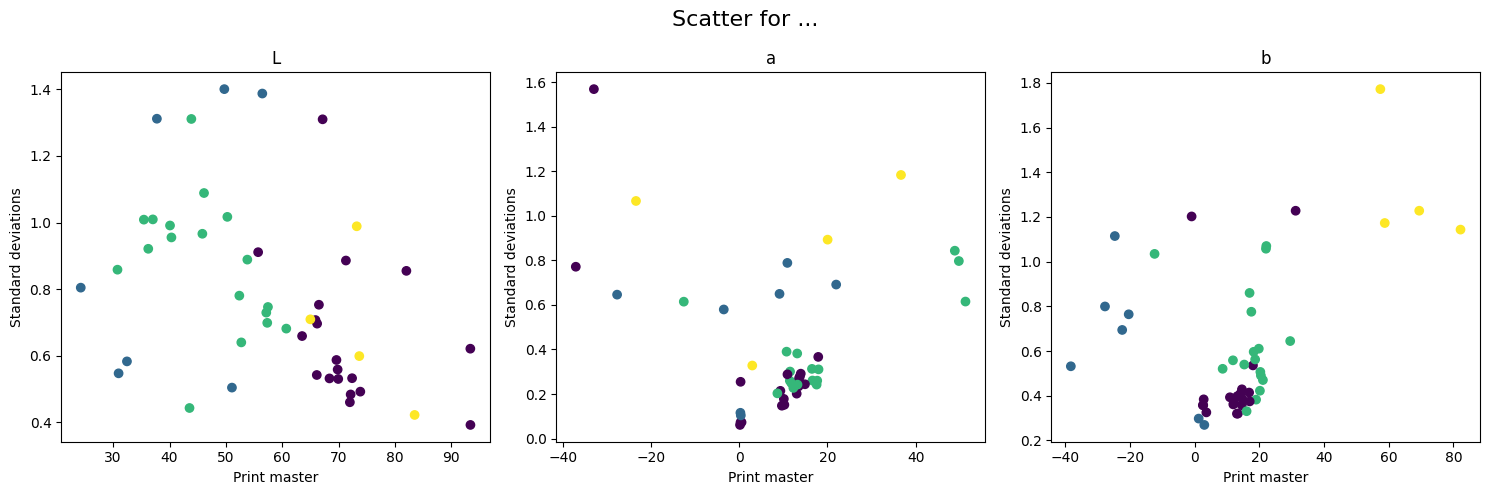

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, color in enumerate(["L", "a", "b"]):
    x, y, c = create_scatter_data_std(df_stds, master_colors_filtered, color)
    if c:
        axes[i].scatter(x, y, c=c, cmap="viridis")
    else:
        axes[i].scatter(x, y)
    axes[i].set_title(f"{color}")
    axes[i].set_xlabel("Print master")
    axes[i].set_ylabel("Standard deviations")

fig.suptitle("Scatter for ...", fontsize=16)
plt.tight_layout()
plt.show()